*Lending Club Case Study*
------------------------------------------------------------


In [1]:
#importing builtin libraries
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Reading dataset
loan = pd.read_csv('loan.csv')
loan.info()
pd.set_option('display.max_columns', 500)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


In [3]:
#-----------------------------------------------------------
#------Removing the extra columns from the original dataset
#-----------------------------------------------------------
unique_values_count = loan.nunique().to_frame()
column_list = unique_values_count[unique_values_count[0] <=1].index.values.tolist()
column_list = column_list + ['member_id','url','desc']
loan_mod = loan.drop(column_list, axis=1)
print("Shape of the Original DataFrame --> " + str(loan.shape))
print("Shape of the DataFrame Post removal of extra columns --> " + str(loan_mod.shape))

Shape of the Original DataFrame --> (39717, 111)
Shape of the DataFrame Post removal of extra columns --> (39717, 45)


In [4]:
#---------------Cleaning and standardization of the Dataframe
#------------------------------------------------------------
#------------1. Removing '%' sign from the corresponding attributes i.e. 'int_rate' , 'revol_util'
#------------2. Converting the Dataype of the attributes as required
#------------3. Removing  'Year' from the corresponding attribute i.e. 'emp_length'
#------------4. Making data case insensitive i.e. Lower case
#------------5. Removing the "months" from the corresponding attribute i.e. 'term'
#------------6. Formatting the date columns i.e. 'issue_d', 'earliest_cr_line', 
#                                                'last_pymnt_d', 'last_credit_pull_d', 
#                                               'next_pymnt_d'

In [5]:
#--1. Removing '%' sign from the corresponding attributes
loan_mod['int_rate'] = loan_mod['int_rate'].str.replace("%","")
loan_mod['revol_util'] = loan_mod['revol_util'].str.replace("%","")
#loan_mod['revol_util'].head()

In [6]:
#--2. Converting the Dataype of the attributes as required
convert_Dtype = {'term':'category',
                'grade':'category',
                'sub_grade':'category',
                'emp_length':'category',
                'home_ownership':'category',
                'verification_status':'category',
                'loan_status':'category',
                'addr_state':'category',
                'inq_last_6mths':'category',
                'open_acc':'category',
                'pub_rec':'category',
                'int_rate': 'float64',
                'revol_util': 'float64'}
loan_mod = loan_mod.astype(convert_Dtype)

In [7]:
#--3. Removing  'Year' from the corresponding attribute i.e. 'emp_length'
loan_mod['emp_length'] = loan_mod['emp_length'].str.replace("years","")
loan_mod['emp_length'] = loan_mod['emp_length'].str.replace("year","")
loan_mod['emp_length'] = loan_mod['emp_length'].str.replace("+","")
loan_mod['emp_length'] = loan_mod['emp_length'].str.replace("< 1","0")
#loan_mod['emp_length'].unique()

In [8]:
#--4. Making data case insensitive i.e. Lower case
column_list = ['emp_title', 'home_ownership', 
               'verification_status', 'loan_status', 
               'purpose', 'title','addr_state']
for x in column_list:
    loan_mod[x] = loan_mod[x].str.lower()

In [9]:
#--5. Removing the "months" from the corresponding attribute i.e. 'term'
tmp = pd.DataFrame(loan_mod['term'].str.split(" ", expand = True))
loan_mod.term = tmp[1]
#loan_mod['term'].unique()

In [10]:
#--6. Formatting the date columns
date_column_list = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d', 'next_pymnt_d']
#loan_mod[date_column_list] = loan_mod[date_column_list].apply(lambda x : pd.to_datetime(x.str.upper(), format='%b-%y', yearfirst=False) ) 
loan_mod[date_column_list] = loan_mod[date_column_list].apply(lambda x : pd.to_datetime(x, format='%b-%y', yearfirst=False) ) 

In [11]:
loan_mod.head(2)

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,pub_rec_bankruptcies
0,1077501,5000,5000,4975.0,36,10.65,162.87,B,B2,NaN,10,rent,24000.0,verified,2011-12-01,fully paid,credit_card,computer,860xx,az,27.65,0,1985-01-01,1,NaN,NaN,3,0,13648,83.7,9,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.0,0.00,0.00,2015-01-01,171.62,NaT,2016-05-01,0.0
1,1077430,2500,2500,2500.0,60,15.27,59.83,C,C4,ryder,0,rent,30000.0,source verified,2011-12-01,charged off,car,bike,309xx,ga,1.00,0,1999-04-01,5,NaN,NaN,3,0,1687,9.4,4,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.0,117.08,1.11,2013-04-01,119.66,NaT,2013-09-01,0.0


In [12]:
loan_mod.shape

(39717, 45)

# Analysing Data

In [13]:
#Function to analyse categorical variable
def analyze_categorical_variables(cat_var,var,tmp_df = deepcopy(loan_mod)):
    tmp_df2 = pd.get_dummies(loan_mod[cat_var])
    tmp_df = pd.concat([tmp_df,tmp_df2],axis=1)
    z = tmp_df[[var]+list(tmp_df2.columns)].groupby(var).sum()
    y = z.div(z.sum(axis=0), axis=1)*100
    return y

### Verifying effect of purpose on charge off percentage

In [14]:
k = analyze_categorical_variables('purpose','loan_status')
k = k.T.reset_index()
k.columns = ['loan_status', 'charged off', 'current', 'fully paid']
k = k.sort_values('charged off',ascending=False).reset_index(drop=True)
k

,loan_status,charged off,current,fully paid
0,small_business,25.984683,4.048140,69.967177
1,renewable_energy,18.446602,0.970874,80.582524
2,educational,17.230769,0.000000,82.769231
3,other,15.852742,3.205610,80.941648
4,moving,15.780446,1.200686,83.018868
5,house,15.485564,3.674541,80.839895
6,medical,15.295815,1.731602,82.972583
7,debt_consolidation,14.843624,3.143608,82.012768
8,vacation,13.910761,1.574803,84.514436
9,home_improvement,11.659946,3.393817,84.946237


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

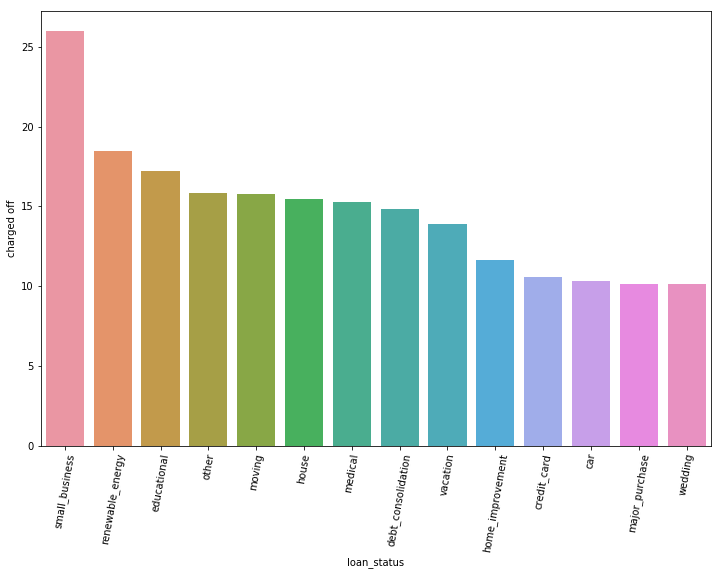

In [15]:
plt.figure(figsize=(12,8))
sns.barplot(y="charged off", x="loan_status", data=k)
plt.xticks(rotation=80)

#### Conclusion
1) Loan for small_business and renewable_energy are more likely to chargeoff.<br/>
2) Loan for credit_card, car, major_purchase & wedding are comparatively safer to lend.
#### Impact : High

### Verifying effects of term on chargeoff percentage

In [16]:
k = analyze_categorical_variables('term','loan_status')
k = k.T
k.sort_values('charged off',ascending=False)

loan_status,charged off,current,fully paid
60,22.596742,10.733453,66.669805
36,11.090872,0.000000,88.909128


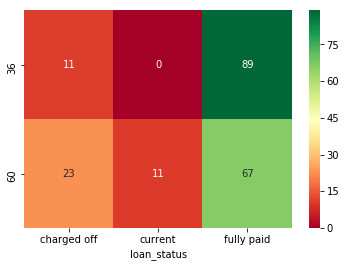

In [17]:
sns.heatmap(k,cmap='RdYlGn',annot=True)

#### Conclusion:
1) Long term loans (60 MONTHS) are more likely to charge off
#### Impact High

### Analysing of verification_status on charge off %

Table V1:
Calculating what % of loans charged off for every income verification status


,loan_status,charged off,current,fully paid
0,not verified,12.658826,1.341528,85.999645
1,source verified,14.358666,3.104035,82.537298
2,verified,16.012179,4.707627,79.280194


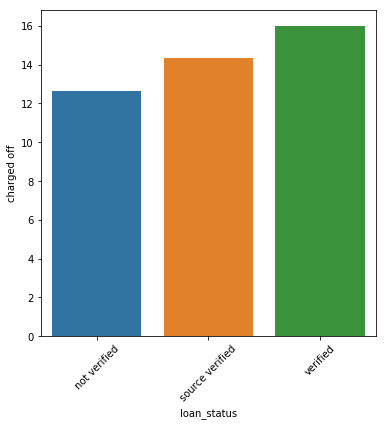

In [18]:
print('Table V1:')
print("Calculating what % of loans charged off for every income verification status")
k = analyze_categorical_variables('verification_status','loan_status')
k = k.T.reset_index()
k.columns = ['loan_status', 'charged off', 'current', 'fully paid']
plt.figure(figsize=(6,6))
sns.barplot(y="charged off", x="loan_status", data=k)
plt.xticks(rotation=45)
k

**Observation:**<br/>
When income source is not verified, 12.65% charge off(default) compared to 16.01% when income is verified

###  Bivariate analysis on year from earliest_cr_line, inq_last_6mths.

<Figure size 432x288 with 0 Axes>

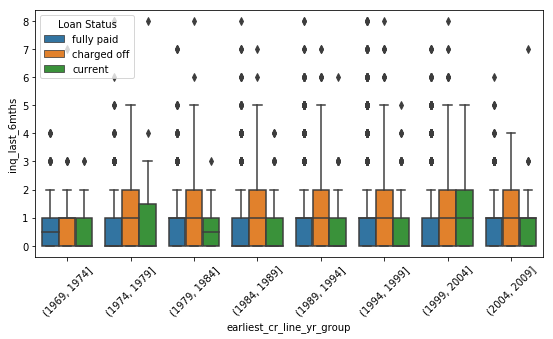

In [19]:
loan_mod['earliest_cr_line'] = pd.to_datetime(loan_mod['earliest_cr_line'], errors='coerce')
loan_mod['earliest_cr_line_yr'] = loan_mod['earliest_cr_line'].dt.year
loan_mod['inq_last_6mths'] = loan_mod['inq_last_6mths'].astype(int)
plt.figure(1)
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
loan_mod['earliest_cr_line_yr_group'] = pd.cut(loan_mod['earliest_cr_line_yr'], bins=range(1969, 2011,5))
ax = sns.boxplot(x="earliest_cr_line_yr_group", y="inq_last_6mths", data=loan_mod,hue='loan_status')
plt.legend(title='Loan Status', loc='upper left')
plt.xticks(rotation=45)
plt.show()

<Figure size 432x288 with 0 Axes>

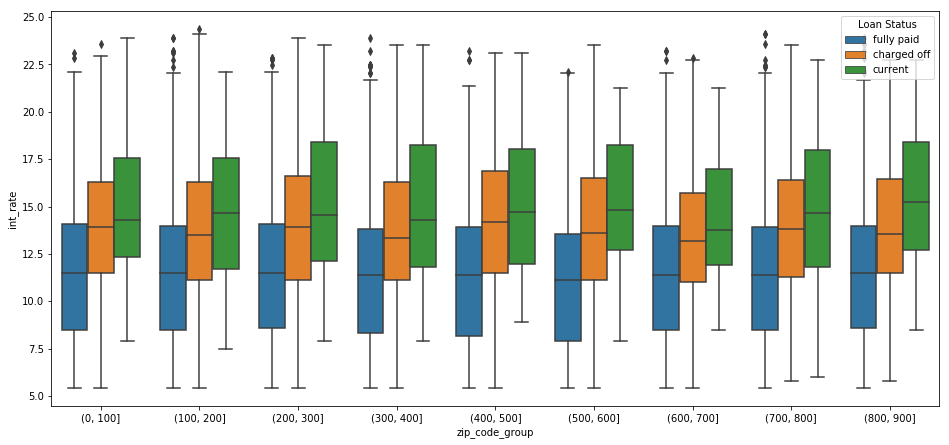

In [20]:

threashold = loan_mod['annual_inc'].quantile(0.98)
tmp_df = loan_mod[loan_mod['annual_inc'] <= threashold ]
tmp_df.loc[:,'zip_code'] = tmp_df['zip_code'].str.replace('xx','')
tmp_df.loc[:,'zip_code'] = tmp_df['zip_code'].str.strip()
tmp_df.loc[:,'zip_code'] = tmp_df['zip_code'].astype(int)
tmp_df.loc[:,'open_acc'] = tmp_df['open_acc'].astype(int)
plt.figure(1)
plt.figure(figsize=(35,16))
plt.subplot(2,2,1)
tmp_df['zip_code_group'] = pd.cut(tmp_df['zip_code'], bins=range(0, 1000,100))
ax = sns.boxplot(x="zip_code_group", y="int_rate", data=tmp_df,hue='loan_status')
plt.legend(title='Loan Status', loc='upper right')
plt.show()

### Plot for DTI vs Annual Income for the loan status

38919


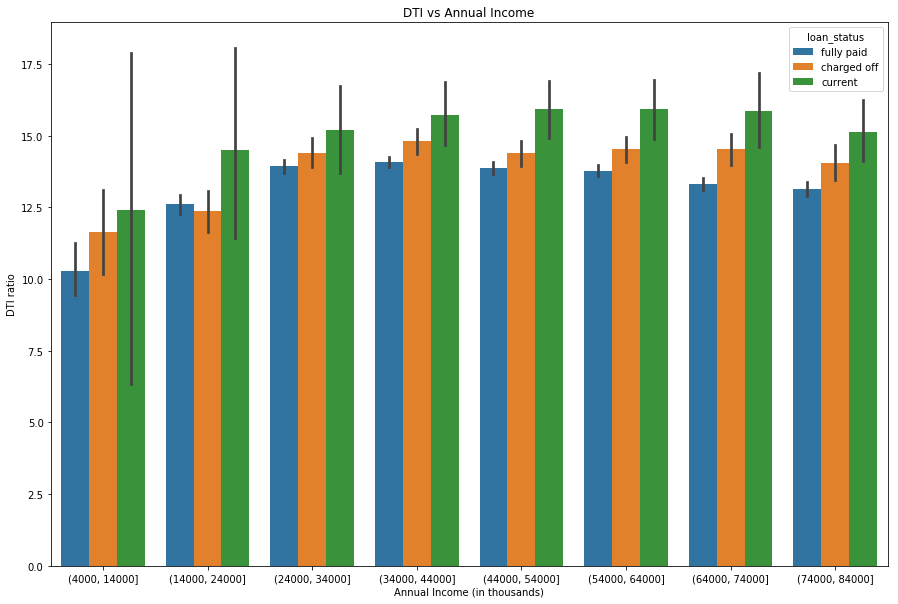

In [21]:
#DTI ratio for each income bucket for Charged Off, Current, and Fully Paid is calculated
#Removing the outliers by taking annual income range from 4000 to 85000

DTI_AnnualIncome = loan_mod[ loan_mod['annual_inc'] < loan_mod['annual_inc'].quantile(.98) ]
print(len(DTI_AnnualIncome))
plt.figure(figsize=(15,10))
DTI_AnnualIncome['dti_group'] = pd.cut(DTI_AnnualIncome['dti'], bins=range(0, 40,5))
DTI_AnnualIncome['annual_inc_group'] = pd.cut(DTI_AnnualIncome['annual_inc'], bins=range(4000, 85000,10000))
ax = sns.barplot(y="dti", x="annual_inc_group", data=DTI_AnnualIncome,hue='loan_status')
ax.set(xlabel='Annual Income (in thousands)', ylabel='DTI ratio', title= 'DTI vs Annual Income')
plt.show()

#---------------------------------------------Observations--------------------------
#If the DTI ratio for Current loan status is greater than that for fully paid - Customer is likely to be defaulted
#Bucket 24000-34000 and 34000-44000 are less likely to default as the ratio difference is considerably less
#-----------------------------------------------------------------------------------

## Other Analysis

### Verifying effect of grade on charge off percentage

In [22]:
k = analyze_categorical_variables('grade','loan_status')
k

,A,B,C,D,E,F,G
loan_status,,,,,,,
charged off,5.969261,11.855241,16.633737,21.066516,25.158339,30.409914,31.962025
current,0.396629,2.870216,3.260064,4.183154,6.298381,6.959009,5.379747
fully paid,93.634110,85.274542,80.106199,74.750330,68.543279,62.631077,62.658228


In [23]:
l = analyze_categorical_variables('loan_status','grade')
l

,charged off,current,fully paid
grade,,,
A,10.698418,3.508772,28.658574
B,25.324329,30.263158,31.107739
C,23.938155,23.157895,19.687405
D,19.868491,19.473684,12.039454
E,12.706593,15.701754,5.911988
F,5.669095,6.403509,1.993930
G,1.794917,1.491228,0.600910


#### Conclusions: 
1) With increase in grade from A to G, charge off percentage increases 5.96% to 31.96% <br/>
2) Most of the charged off people belong to grade B(25.32) & C(23.94)
#### Impact: Medium

### Verifying impacts of inq_last_6mths on chargeoff

In [24]:
k = analyze_categorical_variables('inq_last_6mths','loan_status')
k

,0,1,2,3,4,5,6,7,8
loan_status,,,,,,,,,
charged off,11.813472,15.285753,16.225052,20.308399,15.644172,19.178082,25.0000,28.571429,20.000000
current,3.062176,2.834746,2.718513,2.132546,3.067485,1.369863,1.5625,2.857143,6.666667
fully paid,85.124352,81.879501,81.056435,77.559055,81.288344,79.452055,73.4375,68.571429,73.333333


#### Looks like there is increase in chage off percentage with number of inquiries in last 6 months. But the effect is not liner.
#### Impact : High to Medium

### Verifying impacts of loan_amnt & grade on loan_status

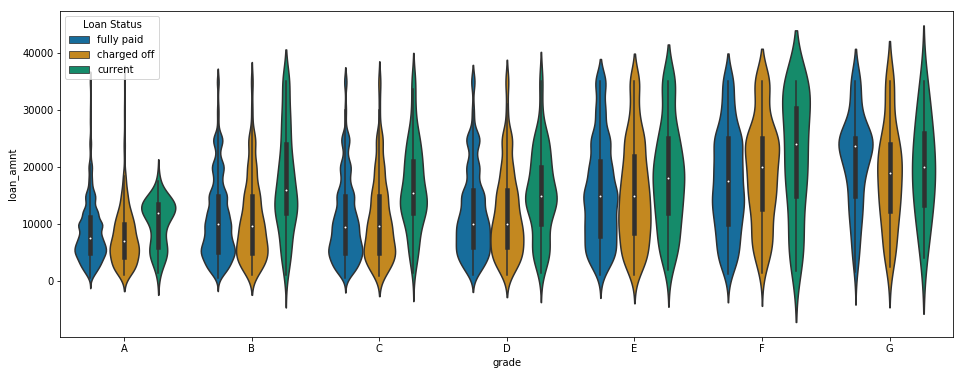

In [25]:
#ALL
plt.figure(figsize=(16, 6))
sns.violinplot(data=loan_mod,y='loan_amnt',x='grade',hue='loan_status',palette="colorblind")
plt.legend(title='Loan Status', loc='upper left')

#### Observations:
Medium value for charge off value remains close to fully paid, for Grades A,B,C,D & E <br/>
Medium value of charge off is greater than fully paid for grade F<br/>
Medium value of charge off is significantly lower than fully paid for grade G <br/>
#### Conclusions:
Unable to conclude anything substantial. But it looks like there are chances of incorrect assignment of grade for records belonging to grade F & G. 

### Analysing impact of verification_status

In [26]:
print('Table V1')
analyze_categorical_variables('verification_status','loan_status')

Table V1


,not verified,source verified,verified
loan_status,,,
charged off,12.658826,14.358666,16.012179
current,1.341528,3.104035,4.707627
fully paid,85.999645,82.537298,79.280194


In [27]:
print('Table V2')
analyze_categorical_variables('loan_status','verification_status')

Table V2


,charged off,current,fully paid
verification_status,,,
not verified,38.066465,19.912281,44.163885
source verified,25.484272,27.192982,25.016692
verified,36.449262,52.894737,30.819423


#### Observation
1) Of all the **charged off** loans the higest **38%** belongs to income **not verified** category (_From Table V2_). But based on _Table V1_, records belong to **verified** are more likely to charge off compared to other two.
#### Impact : Medium

In [28]:
print('Table V3')
loan_mod[['verification_status','loan_status']].groupby('verification_status').count()

Table V3


,loan_status
verification_status,
not verified,16921
source verified,9987
verified,12809


#### Observation
1) Of all the **charged off** loans the higest **38%** belongs to income **not verified** category (_From Table V2_). But based on _Table V1_, records belong to **verified** are more likely to charge off compared to other two.
#### Impact : Medium